In [ ]:
# import necessary libraries

# 📦 Standard Library
import sys
from pathlib import Path
import os

# Data Science Libraries
import pandas as pd
import numpy  as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# 🛠️ Project-Specific Modules
sys.path.append(str(Path().resolve().parent / "src"))
from paths import RAW_DATA_DIR

# SQLAlchemy and SQLite for database operations
import sqlite3


In [9]:
# connect to superstore_sql database

conn = sqlite3.connect(RAW_DATA_DIR/"superstore_sql.db")
cursor = conn.cursor()


In [36]:
# upload csv to work with python
superstore_df = pd.read_csv(RAW_DATA_DIR/"Sample-Superstore.csv", encoding = "latin1")

# EDA

## Category generating the maximum sales revenue

In [10]:
query ="""
SELECT CategoryName, sum(Sales) as revenue
FROM Products p
JOIN OrderDetails o ON p.ProductID = o.ProductID
JOIN Categories c ON c.CategoryID = p.CategoryID
GROUP BY CategoryName
ORDER BY revenue DESC
LIMIT 1
"""
pd.read_sql(query, con=conn)



,CategoryName,revenue
0,Technology,893633.282


##  Profit in this category


In [11]:
query ="""
SELECT CategoryName, sum(Sales) as revenue, sum(Profit)
FROM Products p
JOIN OrderDetails o ON p.ProductID = o.ProductID
JOIN Categories c ON c.CategoryID = p.CategoryID
GROUP BY CategoryName
ORDER BY revenue DESC
LIMIT 1
"""
pd.read_sql(query, con=conn)

,CategoryName,revenue,sum(Profit)
0,Technology,893633.282,153415.7018


    ## Profit per category

In [12]:
# Are they making a loss in any categories?
# Profit margin tells how much profit is made for each dollar of revenue.
query ="""
SELECT 
    CategoryName, 
    sum(Sales) as Revenue, 
    sum(Profit) as Profit,
    (SUM(o.Profit) / SUM(o.Sales)) * 100 AS ProfitMargin
FROM Products p
JOIN OrderDetails o ON p.ProductID = o.ProductID
JOIN Categories c ON c.CategoryID = p.CategoryID
GROUP BY CategoryName
ORDER BY Profit DESC
"""
pd.read_sql(query, con=conn)

,CategoryName,Revenue,Profit,ProfitMargin
0,Technology,893633.2820,153415.7018,17.167635
1,Office Supplies,736748.5940,126113.3459,17.117555
2,Furniture,764284.6523,20098.8892,2.629765


In [ ]:
total_sales = superstore_df["Sales"].sum()
total_profit = superstore_df["Profit"].sum()

In [ ]:
# total revenue per category
revenue_per_category = superstore_df.groupby("Category")["Sales"].sum().reset_index()
profit_per_category = superstore_df.groupby("Category")["Profit"].sum().reset_index()
revenue_per_category["revenue_%"] = revenue_per_category["Sales"] / total_sales
revenue_per_category["profit_%"] = profit_per_category["Profit"] / total_profit



In [ ]:
# revenue % and profit % per category
query = """
SELECT
    CategoryName,
    SUM(Sales) AS TotalSales,
    SUM(Profit) AS TotalProfit,
    (SUM(Sales) / (SELECT SUM(Sales) FROM OrderDetails)) * 100 AS RevenuePercentage,
    (SUM(Profit) / (SELECT SUM(Profit) FROM OrderDetails)) * 100 AS ProfitPercentage
FROM Products p
JOIN OrderDetails o ON p.ProductID = o.ProductID
JOIN Categories c ON c.CategoryID = p.CategoryID
GROUP BY CategoryName
ORDER BY TotalSales DESC
"""
revenue_percentage_per_category = pd.read_sql(query, con=conn)
revenue_percentage_per_category

,CategoryName,TotalSales,TotalProfit,RevenuePercentage,ProfitPercentage
0,Technology,893633.2820,153415.7018,38.900964,53.567492
1,Furniture,764284.6523,20098.8892,33.270258,7.017842
2,Office Supplies,736748.5940,126113.3459,32.071579,44.034447


In [53]:
# avg sales per category
query ="""
SELECT 
    CategoryName, 
    AVG(Sales) as AvgSales
FROM Products p
JOIN OrderDetails o ON p.ProductID = o.ProductID
JOIN Categories c ON c.CategoryID = p.CategoryID
GROUP BY CategoryName
ORDER BY AvgSales DESC
"""
avg_revenue_per_category = pd.read_sql(query, con=conn)
avg_revenue_per_category

,CategoryName,AvgSales
0,Technology,463.262458
1,Furniture,344.893796
2,Office Supplies,119.099352


In [ ]:
# median revenue
query ="""
SELECT
    CategoryName, 
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY Sales) AS MedianRevenue
FROM Products p
JOIN OrderDetails o ON p.ProductID = o.ProductID
JOIN Categories c ON c.CategoryID = p.CategoryID
GROUP BY CategoryName
ORDER BY MedianRevenue DESC
"""
# not possible with sqlite

In [48]:
# median revenue per category
median_revenue_per_category = (
    superstore_df.groupby("Category")["Sales"]
    .median()
    .reset_index(name="MedianRevenue")
    .sort_values(by="MedianRevenue", ascending=False)
)
median_revenue_per_category

,Category,MedianRevenue
0,Furniture,182.220
2,Technology,166.160
1,Office Supplies,27.418


#NOTE - Despite having the highest median revenue, furniture has a really low profit margin, considering the amount of revenue it generates
# 

## Segments generating most profit

In [13]:
query ="""
SELECT 
    Segment, 
    sum(Sales) as Revenue, 
    sum(Profit) as Profit,
    (SUM(od.Profit) / SUM(od.Sales)) * 100 AS ProfitMargin
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY Segment
ORDER BY Profit DESC
"""
pd.read_sql(query, con=conn)

,Segment,Revenue,Profit,ProfitMargin
0,Consumer,1.161401e+06,134119.2092,11.548050
1,Corporate,7.061464e+05,91979.1340,13.025506
2,Home Office,4.296531e+05,60298.6785,14.034269


Consumer segment generated the most profit, though the profit margin is higher in the Home Office Segment

## States generating max and min revenue

In [16]:
# What are the 5 states generating max and min revenue?


query = """
WITH RankedStates AS (
    SELECT r.State, 
           SUM(od.Sales) AS revenue,
           RANK() OVER (ORDER BY SUM(od.Sales) DESC) AS top_rank,
           RANK() OVER (ORDER BY SUM(od.Sales) ASC) AS bottom_rank
    FROM Regions r
    JOIN CustomerAddress c ON r.RegionID = c.RegionID
    JOIN Orders o ON c.CustomerID = o.CustomerID
    JOIN OrderDetails od ON o.OrderID = od.OrderID
    GROUP BY r.State
)
SELECT State, revenue 
FROM RankedStates
WHERE top_rank <= 5 OR bottom_rank <= 5;"""

pd.read_sql(query, con=conn)


,State,revenue
0,California,3.314838e+06
1,New York,1.859365e+06
2,Texas,1.547926e+06
3,Pennsylvania,8.861057e+05
4,Washington,8.622987e+05
5,Maine,1.823970e+04
6,District of Columbia,1.542031e+04
7,West Virginia,1.140548e+04
8,North Dakota,6.113262e+03
9,Wyoming,2.453284e+03


## States generating max and min profit

In [17]:
# What are the 5 states generating max and min profit?
query = """
WITH RankedStates AS (
    SELECT r.State, 
           SUM(od.Profit) AS Profit,
           RANK() OVER (ORDER BY SUM(od.Profit) DESC) AS top_rank,
           RANK() OVER (ORDER BY SUM(od.Profit) ASC) AS bottom_rank
    FROM Regions r
    JOIN CustomerAddress c ON r.RegionID = c.RegionID
    JOIN Orders o ON c.CustomerID = o.CustomerID
    JOIN OrderDetails od ON o.OrderID = od.OrderID
    GROUP BY r.State
)
SELECT State, Profit
FROM RankedStates
WHERE top_rank <= 5 OR bottom_rank <= 5;"""

pd.read_sql(query, con=conn)

,State,Profit
0,California,412087.3696
1,New York,261858.0972
2,Texas,168134.4435
3,Washington,135298.6938
4,Illinois,95157.3852
5,Montana,3454.2440
6,District of Columbia,2830.2780
7,Wyoming,280.7822
8,North Dakota,237.5042
9,West Virginia,-1599.7012


North Carolina and Arkansas are giving losses, so it's worth exploring the reasons. 

## Products with highest sales per segment

In [19]:
# What are the 3 products in each product segment with the highest sales?

query ="""

with cte AS(
SELECT p.ProductName,c.Segment,SUM(od.Sales) as revenue, RANK()OVER(PARTITION BY Segment ORDER BY SUM(od.Sales) DESC) as rank
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN OrderDetails od ON o.OrderID = od.OrderID
JOIN Products p ON od.ProductID = p.ProductID
GROUP BY c.Segment, p.ProductName
)

SELECT ProductName, Segment, revenue
FROM cte
WHERE rank in (1,2,3)


"""
pd.read_sql(query, con=conn)



,ProductName,Segment,revenue
0,Canon imageCLASS 2200 Advanced Copier,Consumer,32899.906
1,HP Designjet T520 Inkjet Large Format Printer ...,Consumer,18374.895
2,HON 5400 Series Task Chairs for Big and Tall,Consumer,17384.304
3,Canon imageCLASS 2200 Advanced Copier,Corporate,17499.950
4,"3D Systems Cube Printer, 2nd Generation, Magenta",Corporate,14299.890
5,Martin Yale Chadless Opener Electric Letter Op...,Corporate,8328.100
6,Cisco TelePresence System EX90 Videoconferenci...,Home Office,22638.480
7,Canon imageCLASS 2200 Advanced Copier,Home Office,11199.968
8,Hewlett Packard LaserJet 3310 Copier,Home Office,9239.846


In [20]:
# Are they the 3 most profitable products as well?

query ="""

with cte AS(
SELECT p.ProductName,c.Segment,SUM(od.Sales) as Revenue,sum(Profit) as Profit, RANK()OVER(PARTITION BY Segment ORDER BY SUM(od.Profit) DESC) as rank
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN OrderDetails od ON o.OrderID = od.OrderID
JOIN Products p ON od.ProductID = p.ProductID
GROUP BY c.Segment, p.ProductName
)

SELECT ProductName, Segment, Revenue, Profit
FROM cte
WHERE rank in (1,2,3)


"""
pd.read_sql(query, con=conn)



,ProductName,Segment,Revenue,Profit
0,Canon imageCLASS 2200 Advanced Copier,Consumer,32899.906,12879.9632
1,Ibico EPK-21 Electric Binding System,Consumer,9449.950,4630.4755
2,HP Designjet T520 Inkjet Large Format Printer ...,Consumer,18374.895,4094.9766
3,Canon imageCLASS 2200 Advanced Copier,Corporate,17499.950,8399.9760
4,"3D Systems Cube Printer, 2nd Generation, Magenta",Corporate,14299.890,3717.9714
5,Fellowes PB300 Plastic Comb Binding Machine,Corporate,7759.800,3030.2019
6,Hewlett Packard LaserJet 3310 Copier,Home Office,9239.846,3935.9344
7,Canon imageCLASS 2200 Advanced Copier,Home Office,11199.968,3919.9888
8,Canon imageCLASS MF7460 Monochrome Digital Las...,Home Office,3991.980,1995.9900


## Best selling products by segment (quantity wise)

In [21]:
# What are the 3 best-seller products in each product segment? (Quantity-wise)

query ="""

with cte AS(
SELECT c.Segment, p.ProductName,SUM(od.Quantity) as Quantity, RANK()OVER(PARTITION BY Segment ORDER BY SUM(od.Quantity) DESC) as rank
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN OrderDetails od ON o.OrderID = od.OrderID
JOIN Products p ON od.ProductID = p.ProductID
GROUP BY c.Segment, p.ProductName
)

SELECT Segment, ProductName, Quantity
FROM cte
WHERE rank in (1,2,3)


"""
pd.read_sql(query, con=conn)



,Segment,ProductName,Quantity
0,Consumer,Staple envelope,104
1,Consumer,Staples,97
2,Consumer,Staples in misc. colors,75
3,Corporate,Staples,90
4,Corporate,Staple envelope,63
5,Corporate,Easy-staple paper,44
6,Home Office,Easy-staple paper,46
7,Home Office,Xerox 1908,32
8,Home Office,Xerox 1881,32


## Worst selling products by category (quantity wise)

In [22]:
# What are the top 3 worst-selling products in every category? (Quantity-wise)

query ="""

with cte AS(
SELECT c.CategoryName, p.ProductName,SUM(od.Quantity) as Quantity, RANK()OVER(PARTITION BY CategoryName ORDER BY SUM(od.Quantity) ASC) as rank
FROM Categories c
JOIN Products p ON c.CategoryID = p.CategoryID
JOIN OrderDetails od ON p.ProductID = od.ProductID
GROUP BY c.CategoryName, p.ProductName
)

SELECT CategoryName, ProductName, Quantity
FROM cte
WHERE rank in (1,2,3)


"""
pd.read_sql(query, con=conn)

,CategoryName,ProductName,Quantity
0,Furniture,"Bush Saratoga Collection 5-Shelf Bookcase, Han...",1
1,Furniture,Global Enterprise Series Seating Low-Back Swiv...,1
2,Furniture,Barricks Non-Folding Utility Table with Steel ...,2
3,Furniture,Ultra Commercial Grade Dual Valve Door Closer,2
4,Office Supplies,Boston 1900 Electric Pencil Sharpener,1
5,Office Supplies,Xerox 20,1
6,Office Supplies,Avery 5,2
7,Office Supplies,Avery Hi-Liter Pen Style Six-Color Fluorescent...,2
8,Office Supplies,Eureka Disposable Bags for Sanitaire Vibra Gro...,2
9,Office Supplies,Grip Seal Envelopes,2


## Unique customers for 2016

In [ ]:
# How many unique customers per month are there for the year 2016?
query ="""
SELECT 
    strftime('%Y', OrderDate) as Year,
    strftime('%m', OrderDate) as Month,
    count(DISTINCT CustomerId) as Customers
FROM Orders
WHERE Year = '2016'
GROUP BY Year, Month
ORDER BY OrderDate ASC

"""

pd.read_sql(query, con=conn)

,Year,Month,Customers
0,2016,01,46
1,2016,02,42
2,2016,03,80
3,2016,04,83
4,2016,05,96
5,2016,06,90
6,2016,07,89
7,2016,08,86
8,2016,09,176
9,2016,10,95


## Customer purchasing patterns by period of time

In [24]:
# count of sales per year

query = """
SELECT COUNT(Sales), strftime('%Y', OrderDate) AS Year
FROM Orders o
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY Year

"""
pd.read_sql(query, con = conn )

,COUNT(Sales),Year
0,1993,2014
1,2102,2015
2,2587,2016
3,3312,2017


In [25]:
# avg purchasing by dow 

# dow - monday as day 1

query = """
SELECT AVG(Sales), strftime('%u', OrderDate) AS DOW 
FROM Orders o
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY DOW
ORDER BY AVG(Sales) DESC

"""
pd.read_sql(query, con = conn )


,AVG(Sales),DOW
0,259.683094,2
1,237.350337,3
2,235.254268,5
3,229.255914,1
4,225.353127,7
5,220.072302,4
6,216.304944,6


Cannot generalize much, besides that weekends are lower on revenue

In [26]:
# avg purchasing by week

query = """
SELECT AVG(Sales), strftime('%U', OrderDate) AS WeekOfYear
FROM Orders o
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY WeekOfYear

"""
pd.read_sql(query, con = conn )


,AVG(Sales),WeekOfYear
0,245.041422,00
1,259.050833,01
2,194.651885,02
3,239.549543,03
4,337.892103,04
5,230.108514,05
6,213.467985,06
7,165.916647,07
8,159.839167,08
9,258.366434,09


In [27]:
# avg purchasing by month

query = """
SELECT AVG(Sales), strftime('%m', OrderDate) AS Month
FROM Orders o
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY Month

"""
pd.read_sql(query, con = conn)


,AVG(Sales),Month
0,249.146550,01
1,199.170838,02
2,294.548116,03
3,206.230731,04
4,210.923553,05
5,212.996763,06
6,207.377601,07
7,225.274877,08
8,222.451154,09
9,244.594609,10


In [28]:
# avg purchasing yearly

query = """
SELECT AVG(Sales), strftime('%Y', OrderDate) AS Year
FROM Orders o
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY Year

"""
pd.read_sql(query, con = conn )

,AVG(Sales),Year
0,242.974159,2014
1,223.849909,2015
2,235.487282,2016
3,221.381418,2017


In [29]:
#total yearly sales

query = """
SELECT sum(Sales) AS TotalSales, strftime('%Y', OrderDate) AS Year
FROM Orders o
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY Year

"""
pd.read_sql(query, con = conn )

,TotalSales,Year
0,484247.4981,2014
1,470532.5090,2015
2,609205.5980,2016
3,733215.2552,2017


total sales increased each year, but the avg sale decreased

In [30]:
# avg sales per quarter

query = """
select
    CASE 
        when 0 + strftime('%m', OrderDate) between  1 and  3 then 'Q1'
        when 0 + strftime('%m', OrderDate) between  4 and  6 then 'Q2'
        when 0 + strftime('%m', OrderDate) between  7 and  9 then 'Q3'
        when 0 + strftime('%m', OrderDate) between 10 and 12 then 'Q4'
    END AS Quarter,
    AVG(sales) AS AverageSales
FROM Orders o 
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY quarter
"""
pd.read_sql(query, con = conn )

# the addition of 0 is there to force the conversion of the result of strftime() to a number.

,Quarter,AverageSales
0,Q1,261.206664
1,Q2,210.146047
2,Q3,219.339802
3,Q4,237.446609


On average Q1 makes the most sales

In [31]:
# total sales per quarter and year

query = """
select
    Strftime('%Y', OrderDate) AS Year,
    CASE 
        when 0 + strftime('%m', OrderDate) between  1 and  3 then 'Q1'
        when 0 + strftime('%m', OrderDate) between  4 and  6 then 'Q2'
        when 0 + strftime('%m', OrderDate) between  7 and  9 then 'Q3'
        when 0 + strftime('%m', OrderDate) between 10 and 12 then 'Q4'
    END AS Quarter,
    SUM(sales) AS TotalSales,
    RANK () OVER (PARTITION BY Strftime('%Y', OrderDate) ORDER BY SUM(sales) DESC ) as Rank
FROM Orders o 
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY Year, Quarter
"""
pd.read_sql(query, con = conn )

,Year,Quarter,TotalSales,Rank
0,2014,Q4,179627.7302,1
1,2014,Q3,143633.2123,2
2,2014,Q2,86538.7596,3
3,2014,Q1,74447.7960,4
4,2015,Q4,182297.0082,1
5,2015,Q3,130259.5752,2
6,2015,Q2,89124.1870,3
7,2015,Q1,68851.7386,4
8,2016,Q4,236098.7538,1
9,2016,Q3,143787.3622,2


Quarterly Revenue Trends Analysis:
Sales show a consistent upward trend within each year, peaking in Q4 across multiple years.
Q3 and Q4 generally have higher revenue, likely due to holiday season demand, promotions, or budget spending towards the end of the fiscal year.
Q1 tends to have the lowest sales, suggesting a post-holiday slump.
This pattern indicates seasonal fluctuations, possibly linked to consumer shopping behavior or business procurement cycles.

## Outliers

In [54]:
superstore_df["Sales"].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

some huge outliers that need to be explored

<Axes: xlabel='Sales', ylabel='Count'>

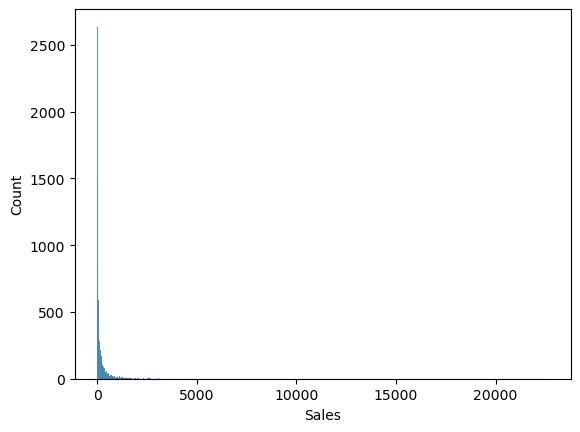

In [55]:
sns.histplot(data=superstore_df, x="Sales")

In [56]:
# count orders over 300 

query = """
SELECT
    count(*)
FROM OrderDetails
WHERE Sales > 300
"""

pd.read_sql(query, con = conn )
#TODO - identify the outliers

,count(*)
0,1904


need to separate in categories to get a proper idea of what's going on

In [57]:
# avg sale per category

query = """
SELECT
    AVG(Sales),
    CategoryName
FROM OrderDetails od
JOIN Products p ON od.ProductID = p.ProductID
JOIN Categories c ON p.CategoryID = c.CategoryID
GROUP BY CategoryName

"""

sales_category = pd.read_sql(query, con = conn )


<Axes: xlabel='CategoryName', ylabel='AVG(Sales)'>

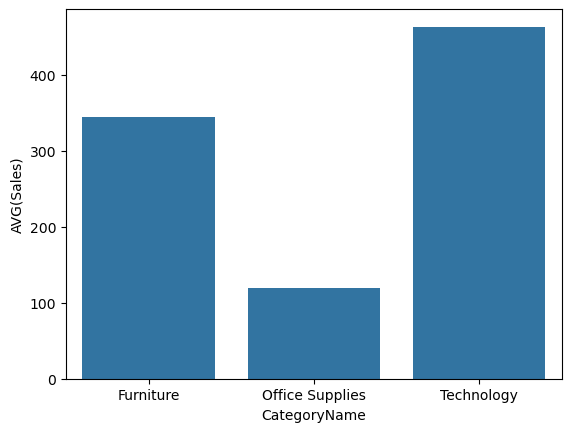

In [58]:
sns.barplot(data=sales_category, x= "CategoryName", y = "AVG(Sales)")

## Distribution of sales

In [61]:
# distribution of sales per category

furniture_query ="""
SELECT CategoryName, Sales
FROM OrderDetails od
JOIN Products p ON od.ProductID = p.ProductID
JOIN Categories c ON p.CategoryID = c.CategoryID
WHERE CategoryName = 'Furniture'

"""
office_supplies_query ="""
SELECT CategoryName, Sales
FROM OrderDetails od
JOIN Products p ON od.ProductID = p.ProductID
JOIN Categories c ON p.CategoryID = c.CategoryID
WHERE CategoryName = 'Office Supplies'

"""
technlogy_query ="""
SELECT CategoryName, Sales
FROM OrderDetails od
JOIN Products p ON od.ProductID = p.ProductID
JOIN Categories c ON p.CategoryID = c.CategoryID
WHERE CategoryName = 'Technology'

"""

furniture_sales = pd.read_sql(furniture_query, con = conn )
office_supplies_sales = pd.read_sql(office_supplies_query, con = conn )
technology_sales= pd.read_sql(technlogy_query, con = conn )


In [62]:
furniture_sales.describe()

,Sales
count,2216.000000
mean,344.893796
std,506.559967
min,1.892000
25%,46.893000
50%,177.004500
75%,414.000000
max,4416.174000


In [63]:
office_supplies_sales.describe()

,Sales
count,6186.000000
mean,119.099352
std,378.118165
min,0.444000
25%,11.880000
50%,27.888000
75%,81.428500
max,9892.740000


In [64]:
technology_sales.describe()

,Sales
count,1929.000000
mean,463.262458
std,1095.225655
min,0.990000
25%,69.990000
50%,176.800000
75%,471.920000
max,22638.480000


<Axes: xlabel='Sales', ylabel='Count'>

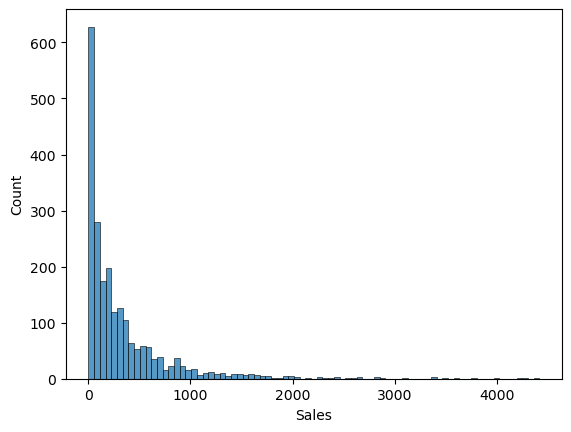

In [65]:
# sales distribution for furniture category
sns.histplot(data=furniture_sales, x="Sales" )

<Axes: xlabel='Sales', ylabel='Count'>

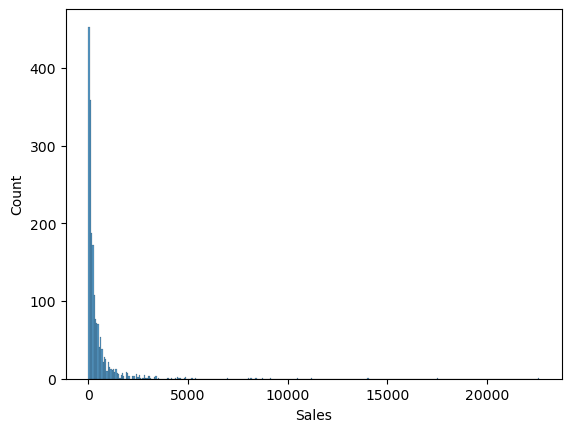

In [66]:
# sales distribution for office supplies category
sns.histplot(data=technology_sales, x="Sales" )

(0.0, 2000.0)

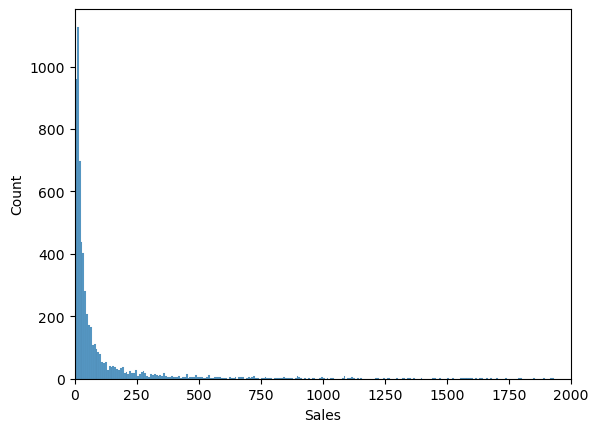

In [67]:
# sales distribution for technology category
sns.histplot(data=office_supplies_sales, x="Sales" ).set_xlim(0,2000)

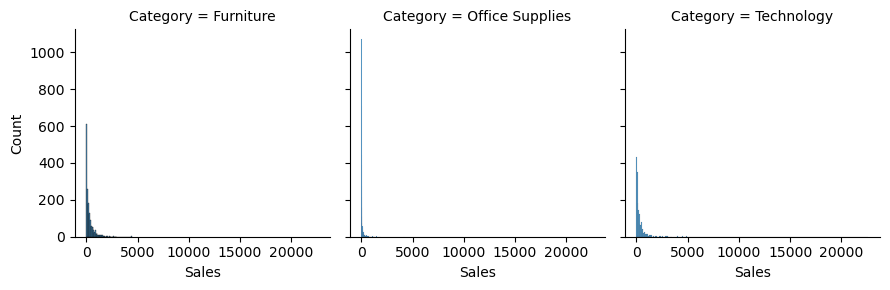

In [68]:
# compare sales distribution for all categories using FacetGrid
grid = sns.FacetGrid (superstore_df, col= "Category")
grid.map(sns.histplot, "Sales")


## Aggregation by state
- Which States and which customers made the highest number of orders? 
- Are they the same as the highest spending States and customers?

In [70]:
# states with highest number of orders

query = """
SELECT
    State,
    count(OrderID) AS Orders
FROM Regions r
JOIN CustomerAddress c on r.RegionID = c.RegionID
JOIN Orders o ON c.CustomerID = o.CustomerID
GROUP BY State
ORDER BY Orders DESC
LIMIT 10

"""

pd.read_sql(query, con = conn )

,State,Orders
0,California,7292
1,New York,3923
2,Texas,3492
3,Pennsylvania,2062
4,Illinois,2000
5,Washington,1794
6,Ohio,1715
7,Florida,1472
8,North Carolina,960
9,Michigan,870


In [72]:
# states with highest revenue and profit

query = """
    SELECT r.State, 
        SUM (Sales) AS Revenue, 
        SUM(od.Profit) AS Profit,
        SUM (Discount) AS Discount
    FROM Regions r
    JOIN CustomerAddress c ON r.RegionID = c.RegionID
    JOIN Orders o ON c.CustomerID = o.CustomerID
    JOIN OrderDetails od ON o.OrderID = od.OrderID
    GROUP BY r.State
    ORDER BY Profit DESC
    LIMIT 10
"""

pd.read_sql(query, con=conn)

,State,Revenue,Profit,Discount
0,California,3.314838e+06,412087.3696,2182.50
1,New York,1.859365e+06,261858.0972,1134.14
2,Texas,1.547926e+06,168134.4435,1286.85
3,Washington,8.622987e+05,135298.6938,483.70
4,Illinois,8.433528e+05,95157.3852,735.24
5,Pennsylvania,8.861057e+05,82402.9320,734.33
6,Michigan,4.324280e+05,61369.7820,251.75
7,Florida,6.356378e+05,59340.2682,505.33
8,Virginia,4.039472e+05,56597.7865,240.23
9,Ohio,7.077477e+05,45348.1359,616.88


## Aggregation at Customer Level

In [73]:
# customers with highest number of orders

query = """
SELECT
    CustomerName,
    count(OrderID) AS Orders
FROM Customers c 
JOIN Orders o ON c.CustomerID = o.CustomerID
GROUP BY CustomerName
ORDER BY Orders DESC
LIMIT 10

"""

pd.read_sql(query, con = conn )

,CustomerName,Orders
0,Emily Phan,17
1,Zuschuss Carroll,13
2,Sally Hughsby,13
3,Patrick Gardner,13
4,Noel Staavos,13
5,Joel Eaton,13
6,Erin Ashbrook,13
7,Chloris Kastensmidt,13
8,Suzanne McNair,12
9,Sanjit Jacobs,12


In [74]:
# customers that generated most revenue

query = """
SELECT
    CustomerName,
    Segment,
    SUM(Sales) AS Revenue
FROM Customers c 
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY CustomerName, Segment
ORDER BY Revenue DESC
LIMIT 10

"""

pd.read_sql(query, con = conn )


,CustomerName,Segment,Revenue
0,Sean Miller,Home Office,25043.050
1,Tamara Chand,Corporate,19052.218
2,Raymond Buch,Consumer,15117.339
3,Tom Ashbrook,Home Office,14595.620
4,Adrian Barton,Consumer,14473.571
5,Ken Lonsdale,Consumer,14175.229
6,Sanjit Chand,Consumer,14142.334
7,Hunter Lopez,Consumer,12873.298
8,Sanjit Engle,Consumer,12209.438
9,Christopher Conant,Consumer,12129.072


In [75]:
# customers that generated most profit

query = """
SELECT
    CustomerName,
    Segment, 
    SUM(Profit) AS Profit
FROM Customers c 
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY CustomerName, Segment
ORDER BY Profit DESC
LIMIT 10

"""

pd.read_sql(query, con = conn )

,CustomerName,Segment,Profit
0,Tamara Chand,Corporate,8981.3239
1,Raymond Buch,Consumer,6976.0959
2,Sanjit Chand,Consumer,5757.4119
3,Hunter Lopez,Consumer,5622.4292
4,Adrian Barton,Consumer,5444.8055
5,Tom Ashbrook,Home Office,4703.7883
6,Christopher Martinez,Consumer,3899.8904
7,Keith Dawkins,Corporate,3038.6254
8,Andy Reiter,Consumer,2884.6208
9,Daniel Raglin,Home Office,2869.0760


the highest spending customer (Sean Miller) doesn't show up in the top 10 profit. Why? 

In [76]:
query = """
SELECT
    CustomerName,
    SUM(Sales) AS Revenue,
    SUM(Profit) AS Profit,
    SUM(Discount) AS Discount
FROM Customers c 
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY CustomerName
ORDER BY Revenue DESC
LIMIT 10

"""

pd.read_sql(query, con = conn )

,CustomerName,Revenue,Profit,Discount
0,Sean Miller,25043.050,-1980.7393,3.7
1,Tamara Chand,19052.218,8981.3239,1.4
2,Raymond Buch,15117.339,6976.0959,1.7
3,Tom Ashbrook,14595.620,4703.7883,0.8
4,Adrian Barton,14473.571,5444.8055,4.8
5,Ken Lonsdale,14175.229,806.8550,5.8
6,Sanjit Chand,14142.334,5757.4119,1.4
7,Hunter Lopez,12873.298,5622.4292,0.2
8,Sanjit Engle,12209.438,2650.6769,2.1
9,Christopher Conant,12129.072,2177.0493,3.1


In [77]:
# top customers by number of orders

query = """
SELECT
    CustomerName,
    COUNT (o.OrderID) AS OrderCount,
    SUM(Sales) AS Revenue,
    SUM(Profit) AS Profit,
    SUM(Discount) AS Discount,
    (SUM(od.Profit) / SUM(od.Sales)) * 100 AS ProfitMargin
FROM Customers c 
JOIN Orders o ON c.CustomerID = o.CustomerID
JOIN OrderDetails od ON o.OrderID = od.OrderID
GROUP BY CustomerName
ORDER BY OrderCount DESC
LIMIT 20

"""

pd.read_sql(query, con = conn )

,CustomerName,OrderCount,Revenue,Profit,Discount,ProfitMargin
0,William Brown,37,6160.1020,714.3311,7.60,11.596092
1,Paul Prost,34,7252.6080,1495.0854,3.70,20.614452
2,Matt Abelman,34,4299.1610,1240.2266,3.20,28.848108
3,John Lee,34,9799.9230,228.9070,3.00,2.335804
4,Seth Vernon,32,11470.9500,1199.4242,5.00,10.456189
5,Jonathan Doherty,32,7610.8640,1050.2668,2.40,13.799574
6,Edward Hooks,32,10310.8800,1393.5154,2.30,13.515000
7,Chloris Kastensmidt,32,3154.8550,141.2831,7.50,4.478276
8,Zuschuss Carroll,31,8025.7070,-1032.1490,7.90,-12.860537
9,Emily Phan,31,5478.0608,144.9578,6.12,2.646152


## High value orders per segment

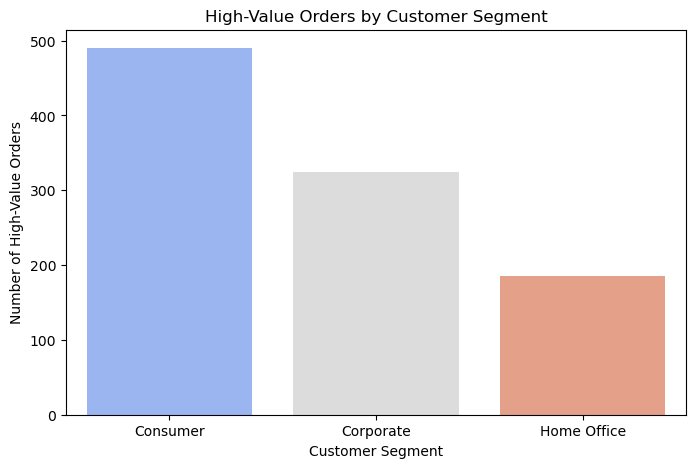

In [ ]:
# Identifying high-ticket items: Define a high-value threshold (top 10% of sales)
high_value_threshold = superstore_df["Sales"].quantile(0.90)  # Top 10% of sales transactions

# Filter high-value transactions
high_value_sales = superstore_df[superstore_df["Sales"] >= high_value_threshold]

# Analyze high-value sales by customer segment
high_value_segment_analysis = high_value_sales.groupby("Segment")["Sales"].count().reset_index()
high_value_segment_analysis.columns = ["Segment", "High-Value Order Count"]

# Visualizing high-value sales by customer segment
plt.figure(figsize=(8, 5))
sns.barplot(x="Segment", y="High-Value Order Count", data=high_value_segment_analysis, palette="coolwarm", hue="Segment", legend= False)
plt.title("High-Value Orders by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Number of High-Value Orders")
plt.show()





In [79]:
#customers with multiple addresses
query = """SELECT CustomerID, COUNT(DISTINCT RegionID) AS RegionCount
FROM CustomerAddress
GROUP BY CustomerID
HAVING COUNT(DISTINCT RegionID) > 1;"""

pd.read_sql(query, con = conn)

,CustomerID,RegionCount
0,AA-10315,5
1,AA-10375,9
2,AA-10480,4
3,AA-10645,6
4,AB-10015,3
...,...,...
775,XP-21865,11
776,YC-21895,5
777,YS-21880,8
778,ZC-21910,13


In [80]:
# addresses with multiple customers
query = """ SELECT RegionID, COUNT(DISTINCT CustomerID) AS CustomerCount
FROM CustomerAddress
GROUP BY RegionID
HAVING COUNT(DISTINCT CustomerID) > 1;"""

pd.read_sql(query, con = conn )

,RegionID,CustomerCount
0,1,17
1,2,65
2,3,12
3,4,56
4,5,5
...,...,...
484,606,3
485,610,2
486,617,2
487,621,2
